
# Modeling



In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from statsmodels.tsa.stattools import adfuller

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
plot_confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imbpipline


## Read in master dataset and drop columns not needed for modeling

---

<p>The following columns are dropped:
    <ul>
        <li><b>Column : Reason</b></li>
        <li>Out Duration : Feature engineered total_duration</li>
        <li>Return Duration : Feature engineered total_duration</li>
        <li>timestamp : Not needed for modeling</li>
        <li>Out Time : Feature engineered dep_time</li>
        <li>Return Time : Feature engineered ret_time</li>
        <li>sort : Not needed for modeling</li>
        <li>Out Stop Cities : Layover cities not needed for modeling</li>
        <li>Return Stop Cities : Layover cities not needed for modeling</li>
        <li>Out Airline : Feature engineered dep_airline</li>
        <li>Return Airline : Feature engineered ret_airline</li>
        <li>Out Stops : Feature engineered total_stops</li>
        <li>Return Stops : Feature engineered total_stops</li>
    </ul>
This was done to reduce dimensionality and resolve any possible redundancies from the feature engineering</p>

In [2]:
df = pd.read_csv('data/masterdf.csv')
col_to_drop = ['Out Duration', 'Return Duration', 'timestamp', 'Out Time', 
                 'Return Time', 'sort', 'Out Stop Cities', 'Return Stop Cities',
                'Out Airline', 'Return Airline', 'Out Stops', 'Return Stops']
df = df.drop(col_to_drop, axis = 1)
df.head()

,Out Cities,Return Cities,Price,departure_date,total_duration,dep_time,ret_time,record_time,dep_airline,ret_airline,departure_day,search_day,total_stops,target,time_diff
0,EWR‐SIN,SIN‐EWR,951,2022-04-10,3245,8:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7
1,EWR‐SIN,SIN‐EWR,979,2022-04-10,3185,9:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0,7
2,EWR‐SIN,SIN‐EWR,994,2022-04-10,2860,11:25,6:10,14,ANA,ANA,Sunday,Sunday,2,1,7
3,EWR‐SIN,SIN‐EWR,994,2022-04-10,3155,6:30,6:10,14,ANA,ANA,Sunday,Sunday,3,0,7
4,EWR‐SIN,SIN‐EWR,998,2022-04-10,3627,11:25,10:10,14,ANA,ANA,Sunday,Sunday,3,0,7



# Defining Functions for

<ol><b>
    <li>Modeling Pipelines</li>
    <li>Printing Scores and Confusion Matrix</li>
    <li>Returning GridSearch Optimized Parameters and Score</li>
    <li>Printing Results of DickeyFuller Test</li>
</b></ol>

---

In [3]:
# Function to fit model and print results from score_matrix_printer
def model_fit_print(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
    
    model.fit(X_train, y_train)
    score_matrix_printer(model, X_train, y_train, X_test, y_test)

def score_matrix_printer(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Cleaning up scores to be more visually appealing
    ascore_train = round((accuracy_score(y_train, train_pred) * 100), 2)
    pscore_train = round((precision_score(y_train, train_pred) * 100), 2)
    rscore_train = round((recall_score(y_train, train_pred) * 100), 2)
    
    ascore_test = round((accuracy_score(y_test, test_pred) * 100), 2)
    pscore_test = round((precision_score(y_test, test_pred) * 100), 2)
    rscore_test = round((recall_score(y_test, test_pred) * 100), 2)
    # Display confusion matrix
    conf_mat = plot_confusion_matrix(model, X_test, y_test)
    # Print Accuracy and Precision for both training and test in a structured format
    print(f"""
    Train Accuracy: {ascore_train}%
    Train Precision: {pscore_train}%
    ==============================
    Test Accuracy: {ascore_test}%
    Test Precision: {pscore_test}%
    """)

In [4]:
# Function to print results from GridSearch in a structured format
def grid_result(grid_model):
    print(f"""
    Optimized score and Parameters
    ==============================
    Score: {grid_model.best_score_}
    ==============================
    Parameters: {grid_model.best_params_}
    """)

In [5]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller(ts):
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(
                    dftest[0:4], 
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    alpha = 0.05
    is_stationary = dftest[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(dftest[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(dftest[1],3)}')
        
    display(dfoutput)

In [6]:
X = df.drop('target', axis=1)
y = df['target']

In [7]:
# numeric_features = X.select_dtypes(exclude="object")
# numeric_features
# ss = StandardScaler()
# num_df = pd.DataFrame(ss.fit_transform(numeric_features),
#                      columns = numeric_features.columns,
#                      index = numeric_features.index)
# num_df.head()


# Instantiating Column Transformer for Pipelines

---

Here I am creating the process for One Hot Encoding my categorical variables and scaling the numeric variables

In [8]:
# ColumnTransformer to handle numerics and categoricals for pipelines
numeric_features = X.select_dtypes(exclude="object").columns
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())] # Standard Scaler is used because we have outliers present
)

categorical_features = X.select_dtypes(include="object").columns
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [9]:
from sklearn.dummy import DummyClassifier

In [10]:
def num_encoder(df_to_encode):
    ss = StandardScaler()

    ss.fit(df_to_encode)
    nums_df = pd.DataFrame(ss.transform(df_to_encode),
                           columns = df_to_encode.columns,
                          index = df_to_encode.index)
    return nums_df

def cat_encoder(df_to_encode):
    ohe = OneHotEncoder(
        drop = 'first',
        sparse = False)
    
    cats = ohe.fit_transform(df_to_encode)
    cat_df = pd.DataFrame(cats,
                            columns = ohe.get_feature_names(),
                            index = df_to_encode.index)
    return cat_df

def split_join(split):
    categories = split.select_dtypes('object')
    numerics = split.select_dtypes(['float64', 'int64'])

    joined = pd.concat([num_encoder(numerics), cat_encoder(categories)], axis = 1)
    return joined

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
X_train_clean = split_join(X_train)
X_test_clean = split_join(X_test)


# Baseline Model

---

Dummy Classifier was used for the Baseline Model<br>
    Producing a score of <b>50.71%</b>

In [12]:
# Baseline model
baseline = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("dummy", DummyClassifier(strategy= 'uniform', random_state=32))
])

baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

0.5052116378138313


# Model One Logistic Regression Model

---

<p>For the first model I chose a Logistic Regression Model<br>
    This was done to see how it would preform before conducting any oversampling<br>
    We see that it has a
    <ul>
        <li><b>Accuracy Score of 99.1%</b></li>
        <li><b>Precision Score of 88.43%</b></li>
    </ul>
It may seem good, but knowing that I need to address the class imbalance present in my data means that this is not an accurate representation of my model's performance</p>


    Train Accuracy: 99.36%
    Train Precision: 90.99%
    Test Accuracy: 99.26%
    Test Precision: 87.5%
    


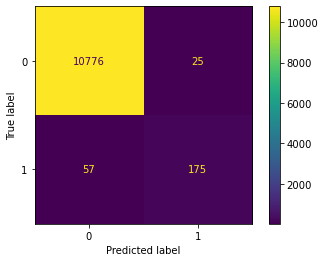

In [13]:
# Logistic Regression model
logreg_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32)) # max_iter called to resolve warning
])

model_fit_print(logreg_model, X, y)

In [14]:
df['target'].value_counts(normalize=True) # To show class imbalance

0    0.979199
1    0.020801
Name: target, dtype: float64


## After oversampling to deal with class imbalance

We see that 
<ul>
    <li><b>Accuracy Score decreased to 97.98%</b></li>
    <li><b>Precision Score decreased to 55.8%</b></li>
</ul>
This is still an improvement from our baseline model, but the precision is not ideal


    Train Accuracy: 98.47%
    Train Precision: 57.6%
    Test Accuracy: 98.46%
    Test Precision: 57.79%
    


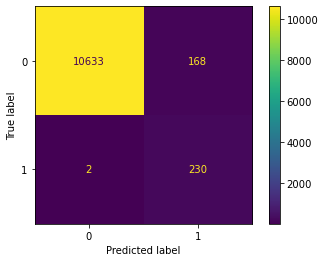

In [15]:
model_1 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("logreg", LogisticRegression(max_iter = 1000, random_state=32)) # max_iter called to resolve warning
])

model_fit_print(model_1, X, y)


# Model Two Decision Tree Classifier

---

<p>The next model I decided to use was a Decison Tree Classifier to improve the precision score
    For the first iteration I did not declare any stop parameters
    As expected the model is severly overfit producing a
<ul>
    <li><b>Training Accuracy Score of 100%</b></li>
    <li><b>Training Precision Score of 100%</b></li>
    ============And============
    <li><b>Testing Accuracy Score of 99.6%</b></li>
    <li><b>Testing Precision Score of 91.72%</b></li>
</ul>
    


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    Test Accuracy: 99.61%
    Test Precision: 91.63%
    


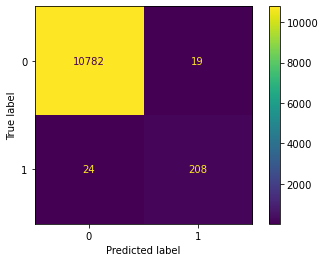

In [16]:
dtree_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(random_state=32))
])

model_fit_print(dtree_model, X, y)


## Finding Optimal Parameters with GridSearch

<p>To address the overfitting and in addition find the optimal parameters for the Decision Tree Classifier I implemented Grid Seach with the following parameters:<br>
<code>"criterion":['gini', 'entropy'],
"max_depth":[1, 10, 25, 50],
"min_samples_split":range(1, 10),
"min_samples_leaf":range(1, 10)</code><br>
==========================================<br>
After running the GridSearch it return the following as optimal parameters:<br>
<code>criterion= 'entropy'
max_depth= 25 
min_samples_split= 7
min_samples_leaf= 2</code><p>

In [17]:
# # Approximately 4 minute run time
# param_dict = {
#     "dtree__criterion":['gini', 'entropy'],
#     "dtree__max_depth":[1, 10, 25, 50],
#     "dtree__min_samples_split":range(1, 10),
#     "dtree__min_samples_leaf":range(1, 10)
# }

# gs = GridSearchCV(estimator=dtree_model,
#                  param_grid=param_dict,
#                  cv=10,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)


## After running with the optimal parameters

We see that 
<ul>
    <li><b>Training Accuracy Score decreased to 99.99%</b></li>
    <li><b>Training Precision Score decreased to 99.88%</b></li>
    ============And============
    <li><b>Testing Accuracy Score increased to 99.99%</b></li>
    <li><b>Testing Precision Score increased to 100%</b></li>
</ul>
These scores are extremely good and the overfitting has been resolved!


    Train Accuracy: 99.98%
    Train Precision: 99.85%
    Test Accuracy: 99.97%
    Test Precision: 100.0%
    


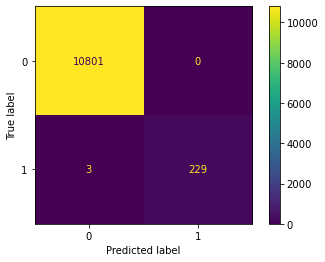

In [18]:
dtree_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("dtree", DecisionTreeClassifier(criterion= 'entropy', max_depth= 25, min_samples_split= 7,
                                    min_samples_leaf= 2, random_state= 32))
])

model_fit_print(dtree_model2, X, y)


    Train Accuracy: 96.47%
    Train Precision: 37.02%
    Test Accuracy: 94.82%
    Test Precision: 26.69%
    


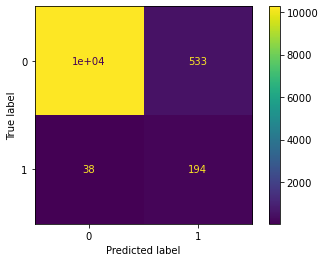

In [19]:
knn_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("knn", KNeighborsClassifier())
])

model_fit_print(knn_model, X, y)

In [20]:
# # Approximately 17 minute run time
# param_dict = {
#     'knn__n_neighbors': range(5, 15),
#     'knn__metric': ['manhattan', 'minkowski', 'euclidean'],
#     'knn__weights' : ['distance', 'uniform']
# }

# gs = GridSearchCV(estimator=knn_model,
#                  param_grid=param_dict,
#                  cv=10,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    Test Accuracy: 97.24%
    Test Precision: 40.85%
    


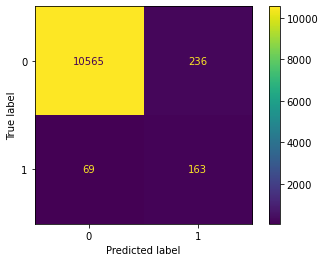

In [21]:
knn_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("knn", KNeighborsClassifier(n_neighbors= 5, metric= 'manhattan', weights= 'distance'))
])

model_fit_print(knn_model2, X, y)


    Train Accuracy: 100.0%
    Train Precision: 100.0%
    Test Accuracy: 99.85%
    Test Precision: 98.21%
    


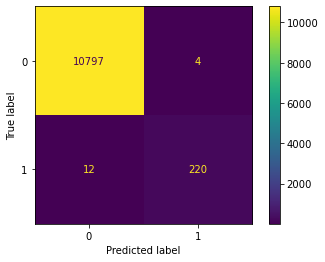

In [22]:
rforest_model = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(random_state = 32))
])

model_fit_print(rforest_model, X, y)

In [23]:
# # Approximately 123 minute run time
# rforest_grid = imbpipline(steps=[
#     ("preprocessor", preprocessor),
#     ('SMOTE', SMOTE(random_state = 32)),
#     ("rf", RandomForestClassifier(random_state = 32))
# ])

# param_grid = {
#     "rf__n_estimators":[30, 100, 150, 200],
#     "rf__criterion":['gini', 'entropy'], 
#     "rf__max_depth":[1, 10, 25, 50],
#     "rf__min_samples_split":range(1, 10),
#     "rf__min_samples_leaf":range(1, 10)
# }            

# gs = GridSearchCV(estimator=rforest_grid,
#                  param_grid=param_grid,
#                  cv=10,
#                  verbose=1,
#                  n_jobs=-1)

# gs.fit(X_train, y_train)
# grid_result(gs)


    Train Accuracy: 99.96%
    Train Precision: 99.41%
    Test Accuracy: 99.85%
    Test Precision: 95.38%
    


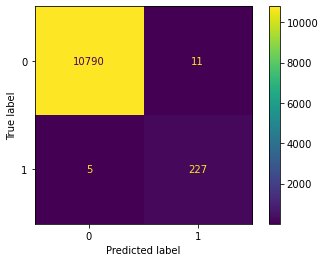

In [24]:
rforest_model2 = imbpipline(steps=[
    ("preprocessor", preprocessor),
    ('SMOTE', SMOTE(random_state = 32)),
    ("rf", RandomForestClassifier(criterion = 'gini', n_estimators = 200, max_depth = 50,
                                  min_samples_leaf = 2, min_samples_split = 2, random_state = 32))
])

model_fit_print(rforest_model2, X, y)

In [25]:
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.metrics import calinski_harabasz_score

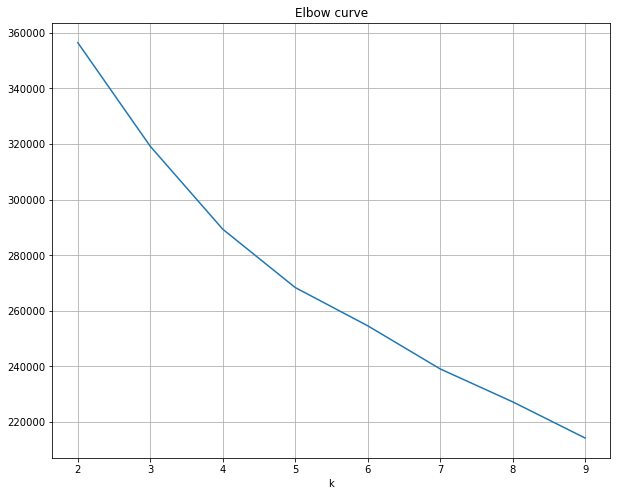

In [26]:
distortions = []

# Calculate SSE for different K
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=32)
    kmeans.fit(X_train_clean) 
    distortions.append(kmeans.inertia_)

# Plot values of SSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Elbow curve')
ax.set_xlabel('k')
ax.plot(range(2, 10), distortions)
ax.grid(True)

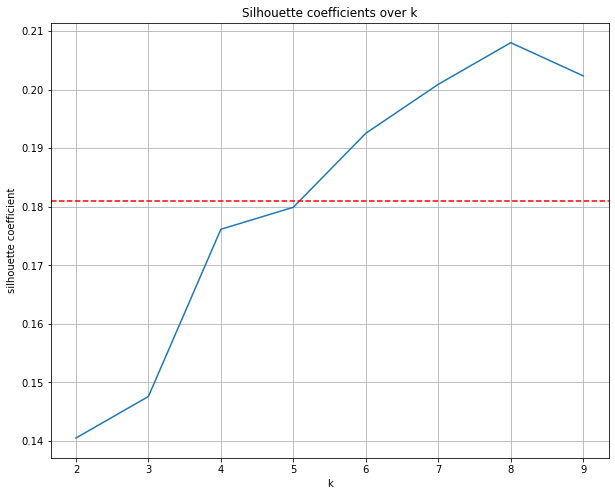

In [27]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X_train_clean)
    silhouette_avg = metrics.silhouette_score(X_train_clean, cluster_labels)
    silhouette_plot.append(silhouette_avg)

# Plot Silhouette coefficient
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Silhouette coefficients over k')
ax.set_xlabel('k')
ax.set_ylabel('silhouette coefficient')
ax.plot(range(2, 10), silhouette_plot)
ax.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
ax.grid(True)

In [28]:
kmeans = KMeans(n_clusters=7, random_state=32)

kmeans.fit(X_train_clean) 

cluster_assignments = kmeans.predict(X_test_clean)

print(calinski_harabasz_score(X_test_clean, cluster_assignments)) #higher score better

1311.3429978052034


In [29]:
from sklearn.ensemble import VotingClassifier

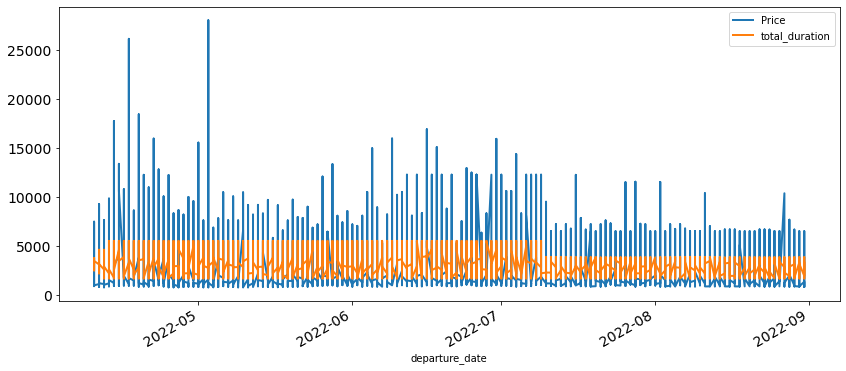

In [30]:
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
time_df = time_df.filter(['Price', 'total_duration'], axis=1)

time_df.plot(figsize=(14,6), linewidth=2, fontsize=14);

In [31]:
ts = time_df['Price']
dicky_fuller(ts)

The data is stationary with a fuller score of 0.0


Test Statistic                -1.205777e+01
p-value                        2.510221e-22
#Lags Used                     5.600000e+01
Number of Observations Used    4.407500e+04
Critical Value (1%)           -3.430498e+00
Critical Value (5%)           -2.861606e+00
Critical Value (10%)          -2.566805e+00
dtype: float64

In [32]:
ts_daily = ts.resample('D').mean()
dicky_fuller(ts_daily)

The data is not stationary with a fuller score of 0.877


Test Statistic                  -0.574736
p-value                          0.876589
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64

In [33]:
ts_daily_diff = ts_daily.diff().dropna()
dicky_fuller(ts_daily_diff)

The data is stationary with a fuller score of 0.041


Test Statistic                  -2.942600
p-value                          0.040614
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64

In [34]:
cutoff = round(ts_daily_diff.shape[0]*0.8)

# Split train and test
train = ts_daily_diff[:cutoff]
test = ts_daily_diff[cutoff:]

# Shift data as Naive Bayse for base model
naive = train.shift(1).fillna(value=None, method='backfill', axis=None, limit=None, downcast=None);

In [35]:
from sklearn.metrics import mean_squared_error
mean_squared_error(train, naive, squared=False)

211.7203990153359

In [36]:
naive_test = test.shift(1).fillna(value=None, method='backfill', axis=None, limit=None, downcast=None);

mean_squared_error(test, naive_test, squared=False)

122.8451343749591

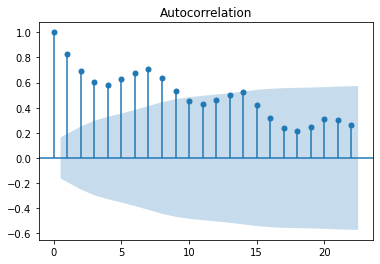

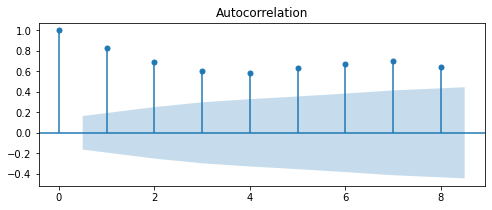

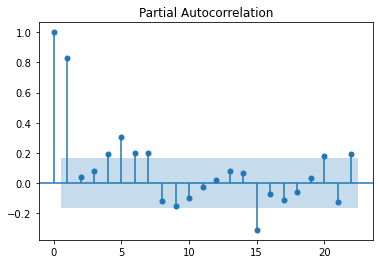

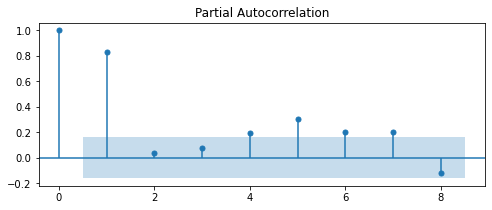

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(ts_daily) #shown below is that an MA term of 3 seems ideal

fig, ax = plt.subplots(figsize=(8,3))
plot_acf(ts_daily, ax=ax, lags=8);

plot_pacf(ts_daily) #shown below is that an AR term of 1 is ideal

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(ts_daily, ax=ax, lags=8);

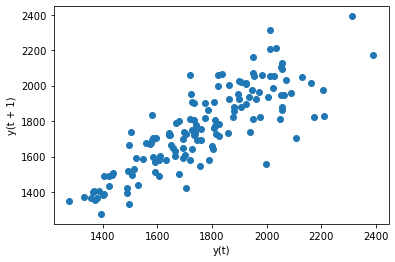

In [38]:
from pandas.plotting import lag_plot
lag_plot(ts_daily)
plt.show()

In [39]:
# from statsmodels.tsa.arima_model import ARIMA
# model = ARIMA(ts_daily, order=(1, 0, 1)) 
# results_ARIMA = model.fit()

import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(ts_daily, order=(3, 1, 2)).fit()
# result = model.
model.summary()

C:\Users\Jun\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jun\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  144
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -876.124
Date:                Fri, 08 Apr 2022   AIC                           1764.248
Time:                        17:27:01   BIC                           1782.025
Sample:                    04-10-2022   HQIC                          1771.472
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8814      0.090      9.793      0.000       0.705       1.058
ar.L2         -0.5317      0.104     -5.135      0.000      -0.735      -0.329
ar.L3         -0.3439      0.082     -4.182      0.000      -0.505      -0.183
ma.L1         -1.2691      0.062    -20.338      0.000      -1.391      -1.147
ma.L2          0.8543      0.060     14.137      0.000       0.736       0.973
sigma2      1.204e+04   1404.822      8.573      0.000    9289.657    1.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.48   Prob(JB):                         0.93
Heteroskedasticity (H):               0.63   Skew:                            -0.06
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
def dummy_ts():
    """ Create a time series x with price 0. """
    df = pd.DataFrame(columns=['departure_date', 'Price'])
    df['departure_date'] = pd.date_range(start='2022-04-01', end='2022-04-10', freq='D')
    tdf = df.set_index('departure_date')
    
    return tdf

filler_time = dummy_ts()
temporarydf = pd.DataFrame(ts_daily)
combined_tsdf = filler_time.append(temporarydf)
backfilled_tsdf = combined_tsdf.bfill()
backfilled_tsdf

,Price
departure_date,
2022-04-01,1760.088889
2022-04-02,1760.088889
2022-04-03,1760.088889
2022-04-04,1760.088889
2022-04-05,1760.088889
...,...
2022-08-27,1422.185714
2022-08-28,1487.992857
2022-08-29,1392.292857


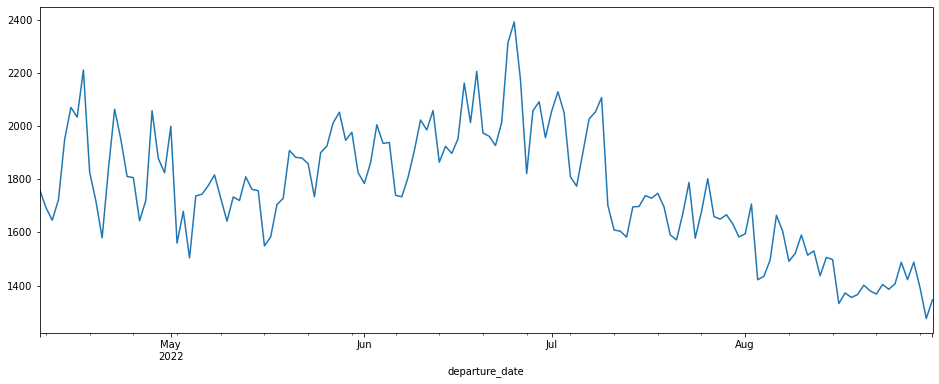

In [41]:
ts_daily.plot(figsize = (16,6));

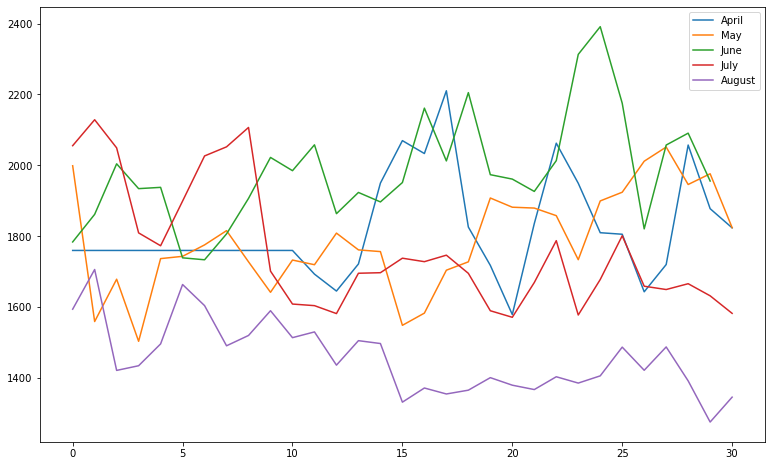

In [42]:
# Use pandas grouper to group values using annual frequency
monthly_groups = backfilled_tsdf.groupby(pd.Grouper(freq ='M'))

month_title_list = ['April', 'May', 'June', 'July', 'August']
# Create a new DataFrame and store yearly values in columns 
apr_monthly = pd.DataFrame()
may_monthly = pd.DataFrame()
jun_monthly = pd.DataFrame()
jul_monthly = pd.DataFrame()
aug_monthly = pd.DataFrame()

n = 0

for mon, group in monthly_groups:
    if n == 0:
        apr_monthly[mon.month] = group.values.ravel()
    if n == 1:
        may_monthly[mon.month] = group.values.ravel()
    if n == 2:
        jun_monthly[mon.month] = group.values.ravel()
    if n == 3:
        jul_monthly[mon.month] = group.values.ravel()
    if n == 4:
        aug_monthly[mon.month] = group.values.ravel()
    n += 1

fig, ax = plt.subplots(figsize=(13,8))
ax.plot(apr_monthly)
ax.plot(may_monthly)
ax.plot(jun_monthly)
ax.plot(jul_monthly)
ax.plot(aug_monthly)
plt.legend([month for month in month_title_list]);

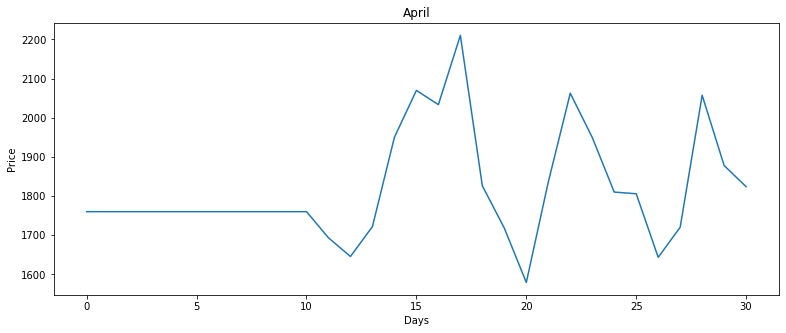

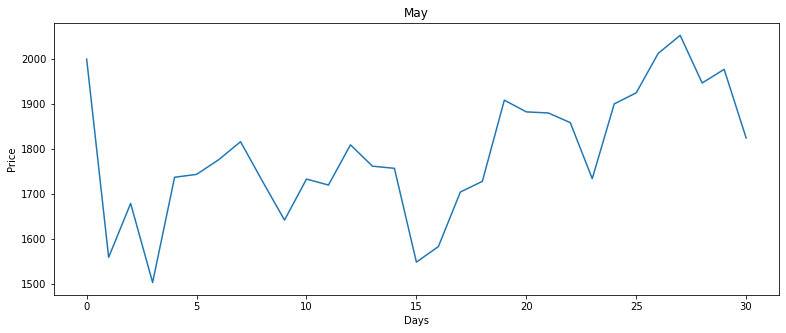

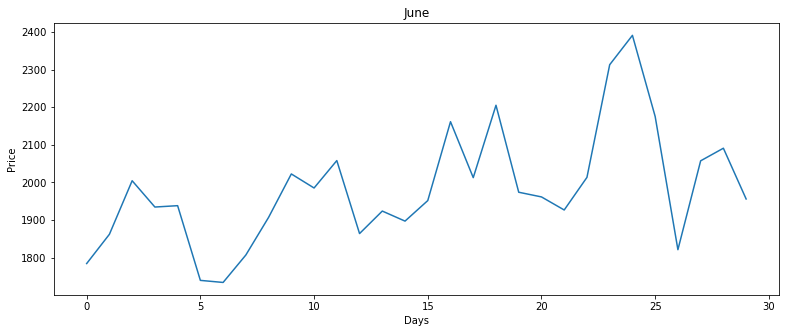

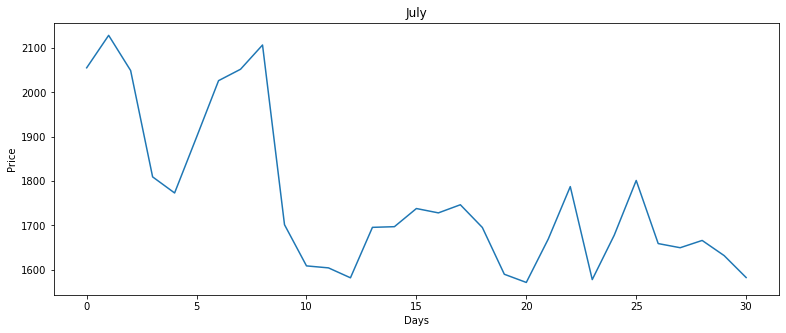

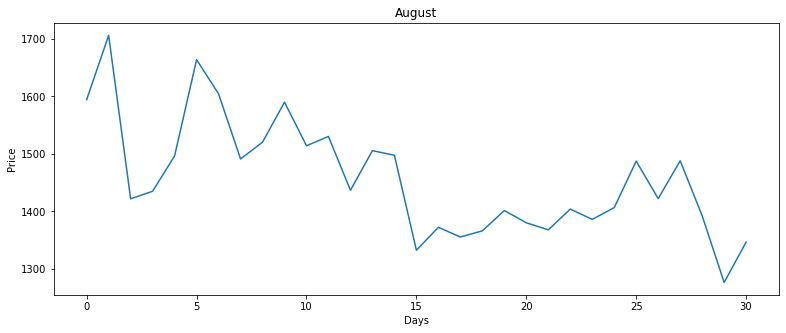

In [43]:
monthly_list = [apr_monthly, may_monthly, jun_monthly,
           jul_monthly, aug_monthly]
i = 0

for month_ts in monthly_list:
    fig, ax = plt.subplots(figsize=(13,5))
    ax.plot(month_ts)
    ax.set_xlabel('Days')
    ax.set_ylabel('Price')
    ax.set_title(label=month_title_list[i])
    i += 1